In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

## Build Vector DB

This notebook assumes that you have run the `data_prep.ipynb` notebook beforehand, so there should be `projects_data_en.json` file in the current directory.

### UpstageEmbeddingFunction for ChromaDB

In [4]:
import chromadb
import numpy as np
from openai import OpenAI
from chromadb import Documents, EmbeddingFunction, Embeddings

# Configure OpenAI client to use Upstage API
client = OpenAI(
    base_url="https://api.upstage.ai/v1",
    api_key=os.getenv("UPSTAGE_API_KEY")
)

chroma_client = chromadb.PersistentClient(path="./chroma_db")
embedding_context_length = 4000

class UpstageEmbeddingFunction(EmbeddingFunction[Documents]):
    def __init__(
        self,
        client,
        model_name: str = "embedding-query",
    ):
        self.client = client
        self.model_name = model_name

    def __call__(self, input: Documents) -> Embeddings:
        if not all(isinstance(item, str) for item in input):
            raise ValueError("Solar embedding only supports text documents, not images")

        batch_process_result = self.client.embeddings.create(model=self.model_name, input=input).data
        passage_embedding_list = [i.embedding for i in batch_process_result]
        return np.array(passage_embedding_list, dtype=np.float32)

embedding_fn = UpstageEmbeddingFunction(client)

### Store data into ChromaDB

In [5]:
import json

# Load the projects data
with open('projects_data_en.json', 'r', encoding='utf-8') as f:
    projects_data = json.load(f)

print(f"Loaded {len(projects_data)} projects")

Loaded 45 projects


In [6]:
try:
    chroma_client.delete_collection(name="projects")
    print("Collection deleted")
except Exception as e:
    print(e)

collection = chroma_client.create_collection(name="projects", embedding_function=embedding_fn)
print("Collection created")

Collection deleted
Collection created


In [7]:
import hashlib
from tqdm import tqdm

# Generate hash based on string
def generate_hash(text):
    """Generate a hash (SHA-256) based on input string"""
    return hashlib.sha256(text.encode('utf-8')).hexdigest()

for project in tqdm(projects_data):
    id = generate_hash(project["descriptive_summary"])

    collection.add(
        ids=[id],
        documents=[project["descriptive_summary"]],
        metadatas=[{"data": str(project)}]
    )

100%|██████████| 45/45 [00:21<00:00,  2.05it/s]


## Agentic System w/ LangGraph

### Imports

In [8]:
import os
from pydantic import BaseModel, Field

from typing import Annotated
from typing_extensions import TypedDict
from langchain_upstage import ChatUpstage
from langchain_core.messages import AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.utils.function_calling import convert_to_openai_tool

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# UPSTAGE_API_KEY = os.getenv("UPSTAGE_API_KEY")

### Dataclasses

In [9]:
class Role(BaseModel):
    role: str = Field(description="A role")
    description: str = Field(description="A description of the role")

class Roles(BaseModel):
    roles: list[Role] = Field(description="A list of roles")

class Participant(BaseModel):
    name: str = Field(description="The name of the participant")
    role: str = Field(description="The role of the participant")
    experience_years: int = Field(description="The experience years of the participant")
    skills: list[str] = Field(description="The skills of the participant")

class Participants(BaseModel):
    participants: list[Participant] = Field(description="A list of participants")

### State

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    extracted_roles: Roles
    paraphrased_query: str
    retrieved_projects: list[dict]
    suggested_participants: Participants
    retrieval_index: int  # start at 0, +5 each round

### Chat instances

In [10]:
solar = ChatUpstage(model="solar-pro-250422")
solar_role = solar.with_structured_output(convert_to_openai_tool(Roles))
solar_participant = solar.with_structured_output(convert_to_openai_tool(Participants))

### Nodes

In [12]:
def role_extraction_agent(state: State):
    messages = state['messages']

    system_prompt = "You are a helpful agent who can extract the required roles of the project."
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt), # Static system message
        MessagesPlaceholder(variable_name="messages"), # Placeholder for history/user input
    ])

    chain = prompt | solar_role
    
    response = chain.invoke({"messages": messages})
    response = Roles(**response)
    
    return {"extracted_roles": response}

def paraphrase_agent(state: State):
    messages = state['messages']
    system_prompt = (
        "You are a helpful agent who paraphrase the user's prompt into a query to find "
        "similar projects from the vector database. MUST return the paraphrased query only."
    )
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt), # Static system message
        MessagesPlaceholder(variable_name="messages"), # Placeholder for history/user input
    ])

    chain = prompt | solar
    response = chain.invoke({"messages": messages})
    return {"paraphrased_query": str(response)}

def retrieval_node(state: State):
    query = state['paraphrased_query']
    index = state.get("retrieval_index", 0)
    collection = chroma_client.get_collection(name="projects", embedding_function=embedding_fn)
    
    # retrieve next 5
    results = collection.query(query_texts=[query], n_results=index + 5)["metadatas"][0]
    
    return {
        "retrieved_projects": results,
        "retrieval_index": index + 5
    }

def suggestion_agent(state: State):
    extracted_roles = state['extracted_roles']
    retrieved_projects = state['retrieved_projects']

    system_prompt = (
        "You are a helpful agent who suggests who is the best fit for the "
        "extracted roles based on the participants of the retrieved projects. "
        "MUST return the best fit person for the extracted roles only."
    )

    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
    ])

    chain = prompt | solar_participant

    # Create a synthetic message for this step
    messages = [
        {
            "role": "user", 
            "content": (
                f"extracted roles: {extracted_roles}\n"
                f"retrieved projects: {retrieved_projects}\n"
            )
        }
    ]

    response = chain.invoke({"messages": messages})
    response = Participants(**response)
    return {"suggested_participants": response}

def check_completion(state: State):
    required = len(state["extracted_roles"].roles)
    suggested = len(state["suggested_participants"].participants)
    
    if suggested >= required:
        return "done"
    elif state["retrieval_index"] >= 20:  # max retrieval limit
        return "done"
    else:
        return "continue"

### Building a graph

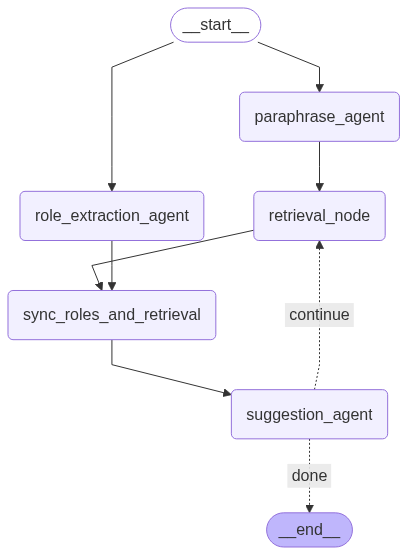

In [13]:
from IPython.display import Image, display

graph_builder = StateGraph(State)

graph_builder.add_node("role_extraction_agent", role_extraction_agent)
graph_builder.add_node("paraphrase_agent", paraphrase_agent)
graph_builder.add_node("retrieval_node", retrieval_node)
graph_builder.add_node("sync_roles_and_retrieval", lambda state: state)
graph_builder.add_node("suggestion_agent", suggestion_agent)

# Create a sequential workflow to ensure proper execution order
graph_builder.add_edge(START, "role_extraction_agent")
graph_builder.add_edge(START, "paraphrase_agent")
graph_builder.add_edge("paraphrase_agent", "retrieval_node")
graph_builder.add_edge("role_extraction_agent", "sync_roles_and_retrieval")
graph_builder.add_edge("retrieval_node", "sync_roles_and_retrieval")
graph_builder.add_edge("sync_roles_and_retrieval", "suggestion_agent")
graph_builder.add_conditional_edges(
    "suggestion_agent",
    check_completion,
    {
        "done": END,
        "continue": "retrieval_node"
    }
)

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### Running the graph

In [21]:
# I want to build a project that brings intelligence to the traditional financial system

participants = None

def stream_graph_updates(user_input: str):
    global participants
    
    print(f"Your request: {user_input}")
    
    for event in graph.stream(
        {
            "messages": [{"role": "user", "content": user_input}],
        }
    ):
        if 'paraphrase_agent' in event:
            print(f"paraphrased query : \n{event['paraphrase_agent']['paraphrased_query']}")
        elif 'role_extraction_agent' in event:
            roles = event['role_extraction_agent']['extracted_roles']
            print(f"extracted roles: \n{roles.model_dump_json(indent=2)}")
        elif 'retrieval_node' in event:
            print(f"retrieved projects: \n{event['retrieval_node']['retrieved_projects']}")
        elif 'suggestion_agent' in event:
            participants = event['suggestion_agent']['suggested_participants']
            print(f"suggested participants: \n{participants.model_dump_json(indent=2)}")

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except Exception as e:
        print(e)
        break

Your request: I want to build a project that brings intelligence to the traditional financial system
paraphrased query : 
content='"Project to integrate artificial intelligence into conventional financial systems"' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 67, 'total_tokens': 79, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'solar-pro-250422', 'system_fingerprint': None, 'id': 'c1d6b5c5-adce-4500-8f72-0621418982fa', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None} id='run--24371eb9-280c-4916-b9ad-fa61e6c9aa0a-0' usage_metadata={'input_tokens': 67, 'output_tokens': 12, 'total_tokens': 79, 'input_token_details': {}, 'output_token_details': {}}
extracted roles: 
{
  "roles": [
    {
      "role": "Project Manager",
      "description": "Manage the project and ensure it is completed on time and within budget."
    },
    {
      "role": "Data Scientist",
      "descrip

In [23]:
print(participants.model_dump_json(indent=2))

{
  "participants": [
    {
      "name": "Dr. Alex Hart",
      "role": "AI Specialist",
      "experience_years": 5,
      "skills": [
        "Machine Learning",
        "Natural Language Processing",
        "Data Mining"
      ]
    },
    {
      "name": "Emma Stone",
      "role": "Financial Analyst",
      "experience_years": 8,
      "skills": [
        "Financial Modeling",
        "Risk Assessment",
        "Economic Forecasting"
      ]
    },
    {
      "name": "Lucas Graham",
      "role": "UI/UX Designer",
      "experience_years": 6,
      "skills": [
        "User-Centered Design",
        "Prototyping",
        "Usability Testing"
      ]
    },
    {
      "name": "Sophia Lee",
      "role": "Data Security Expert",
      "experience_years": 7,
      "skills": [
        "Encryption",
        "Network Security",
        "Compliance"
      ]
    },
    {
      "name": "Michael Brown",
      "role": "Project Manager",
      "experience_years": 10,
      "skills": [
    